<a href="https://colab.research.google.com/github/kitkeat/Effective-Argument-Prediction-NLP/blob/main/2-modelling-evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Book 2 - Modelling and Evaluation

---

Approach:

1. Using 3 types of pretrained models, the models are further fine tuned with the data provided.

2. Next, the prediction of the 3 models are weighted averaged before producing the end output.

  Pretrained models used:
  * DistilBert-base-uncased
  * Deberta-v3-base
  * 90% Sparse BERT-Large (uncased) Prune OFA


In [1]:
# # ! pip install accelerate nvidia-ml-py3
! pip install datasets==2.1.0
! pip install transformers==4.18.0
! pip install sentencepiece==0.1.96
! pip install pytorch-lightning==1.6.5
! pip install torchmetrics==0.9.2
! pip install wandb==0.12.21

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 325 kB 7.8 MB/s 
     |████████████████████████████████| 141 kB 65.1 MB/s 
     |████████████████████████████████| 115 kB 68.5 MB/s 
     |████████████████████████████████| 101 kB 12.9 MB/s 
     |████████████████████████████████| 212 kB 59.7 MB/s 
     |████████████████████████████████| 596 kB 57.5 MB/s 
     |████████████████████████████████| 127 kB 46.0 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.0 MB 6.9 MB/s 
     |██████████████████████████

In [2]:
import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         os.path.join(dirname, filename)
# os.environ["TOKENIZERS_PARALLELISM"] = "false"
# run_type = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

import pandas as pd
pd.set_option("max_colwidth", None)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
from transformers import AutoTokenizer, DataCollatorWithPadding, AdamW, get_cosine_schedule_with_warmup, EarlyStoppingCallback, AutoModel
from datasets import Dataset, Value, ClassLabel, Features, load_metric
import math

import torch
from torch import nn
from torch.utils.checkpoint import checkpoint # need to call when using gradient_checkpointing

from sklearn.metrics import log_loss, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split

from scipy.special import softmax

import pytorch_lightning as pl
from pytorch_lightning import seed_everything
from pytorch_lightning.callbacks import EarlyStopping, TQDMProgressBar
from torchmetrics.functional import f1_score

from torch.utils.data import DataLoader
import torch.nn.functional as F

import spacy
from spacy import displacy

import wandb

from text_unidecode import unidecode
from typing import Dict, List, Tuple
import codecs

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Check GPU availability

In [4]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

cuda:0


# Login to Weight and Bias

In [5]:
try:
  wandb_api = open('/content/drive/MyDrive/Colab Notebooks/WandBapi/wandbapi.txt', 'r').read()
  !wandb login {wandb_api}
except:
  try:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    secret_value = user_secrets.get_secret("wand_api")
    !wandb login {secret_value}

  except:
    print("wandb failed to login...")
    


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [6]:
import time
timestr = time.strftime("%Y%m%d-%H%M%S")
print(f'Current datetime: {timestr}')

Current datetime: 20220804-090710


# Configuration

In [7]:

attributes = ["Adequate" ,"Effective","Ineffective"]

try:
  data_path = pd.read_csv('/kaggle/input/feedback-prize-effectiveness/train.csv')
  test_path = pd.read_csv('/kaggle/input/feedback-prize-effectiveness/test.csv')
except:
  data_path = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/train.csv')
  test_path = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/test.csv')

deberta_config={'name':'deberta',
                'model_name': 'microsoft/deberta-v3-base',
                'existing_tuned_model_name' : 'kitkeat/deberta-v3-base-argumentativewriting',
                'newly_tuned_model_path' : '',
                # 'PATH': '/content/drive/MyDrive/Colab Notebooks/FineTuneModel/deberta_E3Size16Lr3e-05Warm0.01Weight0.01Freeze2Drop0.1Text0.pth',
                # 'model_name': '../input/deberta-v3-base/deberta-v3-base',
                # 'PATH' : '../input/debertav3basefinetuned3172022/deberta_E3Size16Lr3e-05Warm0.01Weight0.01Freeze2Drop0.1Text0.pth',
                'n_labels': 3,
                'batch_size': 16,
                'lr': 3e-5,
                'warmup': 0.01, 
                'weight_decay': 0.01,
                'n_epochs': 4,
                'n_freeze' : 2,#9,
                'p_dropout':0.65,
                'text_method': 2
                }

distilbert_config={'name': 'distilbert',
                'model_name':'distilbert-base-uncased',
                'existing_tuned_model_name' : 'kitkeat/distilbert-based-uncased-argumentativewriting',
                'newly_tuned_model_path' : '',
                # 'PATH':'/content/drive/MyDrive/Colab Notebooks/FineTuneModel/distilbert-frozenembedding&2transformlayer-5epoch-lr6e5-drop02.pth',
                # 'model_name': '../input/transformers-pretrained-distilbert/distilbert-base-uncased-distilled-squad',
                # 'PATH' : '../input/distilberttuned/distilbert-frozenembedding2transformlayer-5epoch-lr6e5-drop02.pth',
                'n_labels': 3,
                'batch_size': 64,
                'lr': 8e-4,#6e-5,
                'warmup': 0.2, 
                'weight_decay': 0.001,
                'n_epochs': 5,#4,
                'n_freeze' : 3,
                'p_dropout':0.6,#0.2,#0.6,
                'text_method': 1
                }

bertofa_config={'name':'bertofa',
                'model_name':'Intel/bert-large-uncased-sparse-90-unstructured-pruneofa',
                'existing_tuned_model_name': 'kitkeat/bert-large-uncased-sparse-90-unstructured-pruneofa-argumentativewriting',
                'newly_tuned_model_path' : '',
                # 'PATH' : '/content/drive/MyDrive/Colab Notebooks/FineTuneModel/Bert_OFA_E3Size64Lr0.0001Warm02Weight1e-06Freeze21Drop001_full.pth',
                # 'model_name': '../input/bertlargeuncasedsparse90unstructuredpruned/bert-large-uncased-sparse-90-unstructured-pruneofa',
                # 'PATH' : '../input/bert-ofa-pretuned3072022/Bert_OFA_E3Size64Lr0.0001Warm02Weight1e-06Freeze21Drop001_full.pth',
                'n_labels': 3,
                'batch_size': 64,
                'lr': 1e-4,
                'warmup': 0.2, 
                'weight_decay': 1e-6,
                'n_epochs': 3,
                'n_freeze' : 21,
                'p_dropout':0.1,
                'text_method': 2
                }

# distilroberta_config={'name':'distilroberta',
#                 # 'model_name': '../input/distilrobertabase/distilroberta-base',
#                 # 'PATH' : '../input/distilrobertafinetuned3072022/epoch7-step1840.pth',
#                 'n_labels': 3,
#                 'batch_size': 128,
#                 'lr': 6e-5,
#                 'warmup': 0.2, 
#                 'weight_decay': 0.001,
#                 'n_epochs': 10,
#                 'n_freeze' : 5,
#                 'p_dropout':0,
#                 'text_method': 2
#                 }

seed_everything(91, workers=True)

Global seed set to 91


91

# Utility

In [8]:
def get_essay(essay_id, is_train=True):

    # INPUT_DIR = '../input/feedback-prize-effectiveness/'
    INPUT_DIR = '/content/drive/MyDrive/Colab Notebooks/Data/'
    parent_path = INPUT_DIR + 'train' if is_train else INPUT_DIR + 'test'
    
    try:
        essay_path = os.path.join(parent_path, f"{essay_id}.txt")
        essay_text = open(essay_path, 'r').read()
    except:
        parent_path = INPUT_DIR + 'train'
        essay_path = os.path.join(parent_path, f"{essay_id}.txt")
        essay_text = open(essay_path, 'r').read()        
    return essay_text

# Freeze the hidden layer within the pretrained model
def freeze(module):
    """
    Freezes module's parameters.
    """
    
    for parameter in module.parameters():
        parameter.requires_grad = False
        
def get_freezed_parameters(module):
    """
    Returns names of freezed parameters of the given module.
    """
    
    freezed_parameters = []
    for name, parameter in module.named_parameters():
        if not parameter.requires_grad:
            freezed_parameters.append(name)
            
    return freezed_parameters

# Remove unicode error (https://www.kaggle.com/competitions/feedback-prize-2021/discussion/313330)
def replace_encoding_with_utf8(error: UnicodeError) -> Tuple[bytes, int]:
    return error.object[error.start : error.end].encode("utf-8"), error.end


def replace_decoding_with_cp1252(error: UnicodeError) -> Tuple[str, int]:
    return error.object[error.start : error.end].decode("cp1252"), error.end

# Register the encoding and decoding error handlers for `utf-8` and `cp1252`.
codecs.register_error("replace_encoding_with_utf8", replace_encoding_with_utf8)
codecs.register_error("replace_decoding_with_cp1252", replace_decoding_with_cp1252)

def resolve_encodings_and_normalize(text: str) -> str:
    """Resolve the encoding problems and normalize the abnormal characters."""
    text = (
        text.encode("raw_unicode_escape")
        .decode("utf-8", errors="replace_decoding_with_cp1252")
        .encode("cp1252", errors="replace_encoding_with_utf8")
        .decode("utf-8", errors="replace_decoding_with_cp1252")
    )
    text = unidecode(text)
    return text

# MODELLING

---

## Dataset

---

Used to convert raw text into tokenized data

In [11]:
class _Dataset(Dataset):
    def __init__(self,data_path,test_path, tokenizer,label_encoder,attributes, max_token_len: int = 512, is_train=True,is_test=False, text_method=0):
        self.data_path = data_path
        self.test_path = test_path
        self.tokenizer = tokenizer
        self.attributes = attributes
        self.max_token_len = max_token_len
        self.is_train = is_train
        self.is_test = is_test
        self.label_encoder = label_encoder
        self.text_method = text_method
        self._prepare_data()

    def _prepare_data(self):



        SEP = self.tokenizer.sep_token # different model uses different to text as seperator (e.g. [SEP], </s>)
        if self.is_test:
#             df = pd.read_csv(self.test_path)
            df = self.test_path
            try:
                df['essay_text']  = df['essay_id'].apply(lambda x: get_essay(x, is_train=False))
            except:
                print("Fail to get essay")
            df['discourse_text'] = df['discourse_text'].apply(resolve_encodings_and_normalize)
#             df['discourse_text'] = df['discourse_text'].replace(r'\n',' ', regex=True)
            
            try:
                if self.text_method == 0:
                    df['text'] = df['discourse_text']
                elif self.text_method == 1:
                    df['text'] = df['discourse_type'] + SEP + df['discourse_text']
                elif self.text_method == 2:
                    df['text'] = df['discourse_type'] + ' ' + df['discourse_text'] + SEP + df['essay_text'] # BERT was trained on 2 sentences
            except:
                df['text'] = df['discourse_text']
                
            try:
                # Validation use
                df = df.loc[:,['text','labels']]
            except:
                # Test use
                df = df.loc[:,['text']]

        else:
#             df = pd.read_csv(self.data_path)
            df = self.data_path
            # df = df.sample(1000)
            try:
                df['essay_text']  = df['essay_id'].apply(lambda x: get_essay(x, is_train=True))
            except:
                print('Fail to get essay')
                
            y = df['discourse_effectiveness']

            train_df, val_df = train_test_split(df, test_size=0.2,stratify=y,random_state=91)

            if self.is_train:
                df = train_df.copy()
            else:
                df = val_df.copy()

            df['discourse_text'] = df['discourse_text'].apply(resolve_encodings_and_normalize)
#             df['discourse_text'] = df['discourse_text'].replace(r'\n',' ', regex=True)
            try:
                if self.text_method == 0:
                    df['text'] = df['discourse_text']
                elif self.text_method == 1:
                    df['text'] = df['discourse_type'] + SEP + df['discourse_text']
                elif self.text_method == 2:
                    df['text'] = df['discourse_type'] + ' ' + df['discourse_text'] + SEP + df['essay_text'] # BERT was trained on 2 sentences
            except:
                df['text'] = df['discourse_text']
                
            df = df.rename(columns={'discourse_effectiveness':'labels'})
            df = df.loc[:,['text','labels']]
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self,index):
        item = self.df.iloc[index]
        text = str(item.text)
        tokens = self.tokenizer.encode_plus(text,
                                  add_special_tokens= True,
                                  return_tensors='pt',
                                  truncation=True,
#                                   padding='max_length',
                                  max_length=self.max_token_len,
                                  return_attention_mask = True)
        if self.is_test:
            return {'input_ids':tokens.input_ids.flatten(),'attention_mask': tokens.attention_mask.flatten()}
        else:
            # # Convert strings to numerics, follow alphabetical order
            attributes = item['labels'].split()
            self.label_encoder.fit(self.attributes)
            attributes = self.label_encoder.transform(attributes)
            attributes = torch.as_tensor(attributes)
            #         attributes = torch.FloatTensor(item[self.attributes])
            return {'input_ids':tokens.input_ids.flatten(),'attention_mask': tokens.attention_mask.flatten(), 'labels':attributes}


## Collate (Dynamic Padding)

---

Dynamically pad tokenized text to match the max length of each batch to reduce computational time

In [13]:
class Collate:
    def __init__(self, tokenizer, isTrain=True):
        self.tokenizer = tokenizer
        self.isTrain = isTrain
        # self.args = args

    def __call__(self, batch):
        output = dict()
        output["input_ids"] = [sample["input_ids"] for sample in batch]
        output["attention_mask"] = [sample["attention_mask"] for sample in batch]
        if self.isTrain:
            output["labels"] = [sample["labels"] for sample in batch]

        # calculate max token length of this batch
        batch_max = max([len(ids) for ids in output["input_ids"]])

        # add padding
        if self.tokenizer.padding_side == "right":
            output["input_ids"] = [s.tolist() + (batch_max - len(s)) * [self.tokenizer.pad_token_id] for s in output["input_ids"]]
            output["attention_mask"] = [s.tolist() + (batch_max - len(s)) * [0] for s in output["attention_mask"]]

#             output["input_ids"] = [torch.cat(s, torch.FloatTensor((batch_max - len(s)) * [0]), 0) for s in output["input_ids"]]
#             output["attention_mask"] = [torch.cat(s, torch.FloatTensor((batch_max - len(s)) * [0]), 0) for s in output["attention_mask"]]
        else:
            output["input_ids"] = [torch.FloatTensor((batch_max - len(s)) * [self.tokenizer.pad_token_id].tolist()) + s.tolist() for s in output["input_ids"]]
            output["attention_mask"] = [torch.FloatTensor((batch_max - len(s)) * [0]) + s.tolist() for s in output["attention_mask"]]
            
        # convert to tensors
        output["input_ids"] = torch.tensor(output["input_ids"], dtype=torch.long)
        output["attention_mask"] = torch.tensor(output["attention_mask"], dtype=torch.long)
        if self.isTrain:
            output["labels"] = torch.tensor(output["labels"], dtype=torch.long)
        return output



## Data Module

---

Data preparation by calling dataset and passing it to the dataloader where the data is collated and batched

In [14]:
class _Data_Module(pl.LightningDataModule):

    def __init__(self, data_path, test_path,attributes,label_encoder,tokenizer, model_name, batch_size: int = 8, max_token_length: int = 512,text_method=0 ):
        super().__init__()
        self.data_path = data_path
        self.test_path = test_path
        self.attributes = attributes
        self.batch_size = batch_size
        self.max_token_length = max_token_length
        self.model_name = model_name
        self.tokenizer = tokenizer #AutoTokenizer.from_pretrained(model_name)
        self.label_encoder = label_encoder
        self.text_method = text_method

    def setup(self, stage = None):
        if stage in (None, "fit"):
            self.train_dataset = _Dataset(self.data_path, self.test_path, label_encoder = self.label_encoder,  attributes=self.attributes, is_train=True, tokenizer=self.tokenizer,text_method=self.text_method)
            self.val_dataset = _Dataset(self.data_path, self.test_path, label_encoder = self.label_encoder, attributes=self.attributes, is_train=False,  tokenizer=self.tokenizer,text_method=self.text_method)
        if stage == 'predict':
            self.test_dataset = _Dataset(self.data_path, self.test_path, label_encoder = self.label_encoder, attributes=self.attributes, is_train=False,is_test=True, tokenizer=self.tokenizer,text_method=self.text_method)


    def train_dataloader(self):
        collate_fn = Collate(self.tokenizer, 
                             isTrain=True)

        return DataLoader(self.train_dataset, 
                          batch_size = self.batch_size, 
                          num_workers=2, 
                          shuffle=True,
                          collate_fn = collate_fn)

    def val_dataloader(self):
        collate_fn = Collate(self.tokenizer, 
                             isTrain=True)

        return DataLoader(self.val_dataset, 
                          batch_size = self.batch_size, 
                          num_workers=2, 
                          shuffle=False,
                          collate_fn = collate_fn)

    def predict_dataloader(self):
        collate_fn = Collate(self.tokenizer, 
                             isTrain=False)

        return DataLoader(self.test_dataset, 
                          batch_size = self.batch_size, 
                          num_workers=2, 
                          shuffle=False,
                          collate_fn = collate_fn)


## Classifier

---

4 Types of classifier module were created according to different pretrained model:

1. Bert Pruned OFA (https://huggingface.co/Intel/bert-large-uncased-sparse-90-unstructured-pruneofa)
2. DistilBert (https://huggingface.co/distilbert-base-uncased)
3. Deberta-v3-base (https://huggingface.co/microsoft/deberta-v3-base)
4. DistilRoberta (https://huggingface.co/distilroberta-base)

The classifier module comprises of 5 components:

* Computations (init)
* Train Loop (training_step)
* Validation Loop (validation_step)
* Prediction Loop (predict_step)
* Optimizers and LR Schedulers (configure_optimizers)


### 1. BertOFA Classifier

In [15]:
class BertOFA_Text_Classifier(pl.LightningModule):
    
    def __init__(self, config: dict,data_module):
        super().__init__()
        self.config = config
        self.data_module=data_module
        self.pretrained_model = AutoModel.from_pretrained(config['model_name'], return_dict = False)
        freeze((self.pretrained_model).embeddings)
        freeze((self.pretrained_model).encoder.layer[:config['n_freeze']])
        print(get_freezed_parameters(self.pretrained_model))
        # Adding an additional hidden layer on top of the pretrained model
        self.hidden = torch.nn.Linear(self.pretrained_model.config.hidden_size, self.pretrained_model.config.hidden_size)
        
        # Adding classifier on top of the pretrained model
        self.classifier = torch.nn.Linear(self.pretrained_model.config.hidden_size, self.config['n_labels'])
        
        # Used to initialize the weight of the newly created classifier layer, not sure whether hidden layer need it or not
        torch.nn.init.xavier_uniform_(self.classifier.weight)
        
        self.loss_func = nn.CrossEntropyLoss() # do not put SoftMax, just use CrossEntropyLoss
        
        self.dropout = nn.Dropout(config['p_dropout'])

    # For inference        
    def forward(self, input_ids, attention_mask, labels = None):
        outputs = self.pretrained_model(input_ids = input_ids, attention_mask = attention_mask)
#         pooled_output = torch.mean(outputs.last_hidden_state, 1) 
#         pooled_output = self.dropout(pooled_output)
#         pooled_output = self.dropout(outputs[1])
        pooled_output = self.hidden(outputs[1])
        pooled_output = F.relu(pooled_output)
        pooled_output = self.hidden(pooled_output)
        pooled_output = F.relu(pooled_output)
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        # calculate loss
        loss = 0
        if labels is not None:
            loss = self.loss_func(logits,labels)
        return loss, logits
    
    def training_step(self, batch, batch_index):
        loss, logits = self(**batch)  # self(**batch) = model(**batch), where **batch = unpack batch
        f1 = f1_score(logits.argmax(dim=1),batch['labels'],num_classes=3,multiclass=True)
        f1_weighted = f1_score(logits.softmax(dim=1),batch['labels'],num_classes=3,multiclass=True,average='weighted')
        wandb.log({"Training Loss": loss.item(),'Train F1 Score':f1,'Train F1_weighted Score':f1_weighted})
        self.log("f1", f1, on_step=False,on_epoch=True, prog_bar = True, logger=True)
        self.log("f1_weighted", f1_weighted, on_step=False,on_epoch=True, prog_bar = True, logger=True)
        self.log("loss ", loss,on_step=False,on_epoch = True, prog_bar = True, logger=True)
        return {"loss":loss}#, "predictions":logits, "labels": batch["labels"],"progress_bar":pbar}
    
    def validation_step(self, batch, batch_index):
        loss, logits = self(**batch)
        f1 = f1_score(logits.argmax(dim=1),batch['labels'],num_classes=3,multiclass=True)
        f1_weighted = f1_score(logits.softmax(dim=1),batch['labels'],num_classes=3,multiclass=True,average='weighted')
        wandb.log({"Validation Loss": loss.item(),'Validation F1 Score':f1,'Validation F1_weighted Score':f1_weighted})
        self.log("f1", f1, on_step=False,on_epoch=True, prog_bar = True, logger=True)
        self.log("f1_weighted", f1_weighted, on_step=False,on_epoch=True, prog_bar = True, logger=True)
        self.log("val_loss", loss, on_step=False,on_epoch = True, prog_bar = True, logger=True)
        return {"val_loss": loss}#, "predictions":logits, "labels": batch["labels"]}

    def predict_step(self, batch, batch_index):
        loss, logits = self(**batch)
        return logits

    def configure_optimizers(self):
        train_size = len(self.data_module.train_dataloader())
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.config['lr'], weight_decay=self.config['weight_decay'])
        total_steps = train_size/self.config['batch_size']
        warmup_steps = math.floor(total_steps * self.config['warmup'])
        scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps)
        return [optimizer],[scheduler]

### 2. DistilBert classifier

In [16]:
class DistilBert_Text_Classifier(pl.LightningModule):
    
    def __init__(self, config: dict,data_module):
        super().__init__()
        self.config = config
        self.data_module=data_module
        self.pretrained_model = AutoModel.from_pretrained(config['model_name'], return_dict = True)
        freeze((self.pretrained_model).embeddings)
        freeze((self.pretrained_model).transformer.layer[:config['n_freeze']])
        print(get_freezed_parameters(self.pretrained_model))
        # Adding an additional hidden layer on top of the pretrained model
        self.hidden = torch.nn.Linear(self.pretrained_model.config.hidden_size,self.pretrained_model.config.hidden_size)
#         self.hidden2 = torch.nn.Linear(self.pretrained_model.config.hidden_size,100)

#         self.batchnorm = nn.BatchNorm1d(self.pretrained_model.config.hidden_size)
        # Adding classifier on top of the pretrained model
        self.classifier = torch.nn.Linear(self.pretrained_model.config.hidden_size, self.config['n_labels'])
        
        # Used to initialize the weight of the newly created classifier layer, not sure whether hidden layer need it or not
        torch.nn.init.xavier_uniform_(self.classifier.weight)
        
        self.loss_func = nn.CrossEntropyLoss() # do not put SoftMax, just use CrossEntropyLoss
        
        self.dropout = nn.Dropout(config['p_dropout'])

    # For inference        
    def forward(self, input_ids, attention_mask, labels = None):
        output = self.pretrained_model(input_ids = input_ids, attention_mask = attention_mask)
        logits = self.classifier(output.last_hidden_state)
        pooled_output = torch.mean(output.last_hidden_state, 1) 
        pooled_output = self.hidden(pooled_output)
        pooled_output = F.relu(pooled_output)
#         pooled_output = self.batchnorm(pooled_output)
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
            
        # calculate loss
        loss = 0
        if labels is not None:
            loss = self.loss_func(logits,labels)
        return loss, logits
    
#     def training_step(self, batch, batch_index):
#         logits = self(**batch)  # self(**batch) = model(**batch), where **batch = unpack batch
# #         print(f"batch[labels] = {batch['labels']}")
# #         print(f"{type(batch['labels'])}")
#         class_weights=class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(batch['labels'].tolist()),y=batch['labels'].tolist())
#         class_weights=torch.tensor(class_weights,dtype=torch.float)
#         loss_func = nn.CrossEntropyLoss(weight=class_weights,reduction='mean').to('cuda:0')
#         loss = loss_func(logits,batch['labels']).to('cuda:0')
        
#         f1 = f1_score(logits.argmax(dim=1),batch['labels'],num_classes=3,multiclass=True)
#         f1_weighted = f1_score(logits.softmax(dim=1),batch['labels'],num_classes=3,multiclass=True,average='weighted')
#         wandb.log({"Training Loss": loss.item(),'Train F1 Score':f1,'Train F1_weighted Score':f1_weighted})
#         self.log("f1", f1, on_step=False,on_epoch=True, prog_bar = True, logger=True)
#         self.log("f1_weighted", f1_weighted, on_step=False,on_epoch=True, prog_bar = True, logger=True)
#         self.log("loss ", loss,on_step=False,on_epoch = True, prog_bar = True, logger=True)
#         return {"loss":loss}#, "predictions":logits, "labels": batch["labels"],"progress_bar":pbar}
    
#     def validation_step(self, batch, batch_index):
#         logits = self(**batch)
# #         print(f"batch[labels] = {batch['labels']}")
#         class_weights=class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(batch['labels'].tolist()),y=batch['labels'].tolist())
#         class_weights=torch.tensor(class_weights,dtype=torch.float)
#         loss_func = nn.CrossEntropyLoss(weight=class_weights,reduction='mean').to('cuda:0')
#         loss = loss_func(logits,batch['labels']).to('cuda:0')
        
        
#         f1 = f1_score(logits.argmax(dim=1),batch['labels'],num_classes=3,multiclass=True)
#         f1_weighted = f1_score(logits.softmax(dim=1),batch['labels'],num_classes=3,multiclass=True,average='weighted')
#         wandb.log({"Validation Loss": loss.item(),'Validation F1 Score':f1,'Validation F1_weighted Score':f1_weighted})
#         self.log("f1", f1, on_step=False,on_epoch=True, prog_bar = True, logger=True)
#         self.log("f1_weighted", f1_weighted, on_step=False,on_epoch=True, prog_bar = True, logger=True)
#         self.log("val_loss", loss, on_step=False,on_epoch = True, prog_bar = True, logger=True)
#         return {"val_loss": loss}#, "predictions":logits, "labels": batch["labels"]}
#     
#     def predict_step(self, batch, batch_index):
#         logits = self(**batch)
#         return logits

    def training_step(self, batch, batch_index):
        loss, logits = self(**batch)  # self(**batch) = model(**batch), where **batch = unpack batch
        f1 = f1_score(logits.argmax(dim=1),batch['labels'],num_classes=3,multiclass=True)
        f1_weighted = f1_score(logits.softmax(dim=1),batch['labels'],num_classes=3,multiclass=True,average='weighted')
        wandb.log({"Training Loss": loss.item(),'Train F1 Score':f1,'Train F1_weighted Score':f1_weighted})
        self.log("f1", f1, on_step=True,on_epoch=True, prog_bar = True, logger=True)
        self.log("f1_weighted", f1_weighted, on_step=True,on_epoch=True, prog_bar = True, logger=True)
        self.log("loss ", loss,on_step=True,on_epoch = True, prog_bar = True, logger=True)
        return {"loss":loss}#, "predictions":logits, "labels": batch["labels"],"progress_bar":pbar}
    
    def validation_step(self, batch, batch_index):
        loss, logits = self(**batch)
        f1 = f1_score(logits.argmax(dim=1),batch['labels'],num_classes=3,multiclass=True)
        f1_weighted = f1_score(logits.softmax(dim=1),batch['labels'],num_classes=3,multiclass=True,average='weighted')
        wandb.log({"Validation Loss": loss.item(),'Validation F1 Score':f1,'Validation F1_weighted Score':f1_weighted})
        self.log("f1", f1, on_step=True,on_epoch=True, prog_bar = True, logger=True)
        self.log("f1_weighted", f1_weighted, on_step=True,on_epoch=True, prog_bar = True, logger=True)
        self.log("val_loss", loss, on_step=True,on_epoch = True, prog_bar = True, logger=True)
        return {"val_loss": loss}#, "predictions":logits, "labels": batch["labels"]}

    def predict_step(self, batch, batch_index):
        loss, logits = self(**batch)
        return logits
    
    def configure_optimizers(self):
        train_size = len(self.data_module.train_dataloader())
        print(train_size)
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.config['lr'], weight_decay=self.config['weight_decay'])
        total_steps = train_size/self.config['batch_size']
        warmup_steps = math.floor(total_steps * self.config['warmup'])
        scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps)
        return [optimizer],[scheduler]

### 3. Deberta Classifier

In [17]:
class DeBerta_Text_Classifier(pl.LightningModule):
    
    def __init__(self, config: dict,data_module):
        super().__init__()
        self.config = config
        self.data_module = data_module
        self.pretrained_model = AutoModel.from_pretrained(config['model_name'], return_dict = True)
        freeze((self.pretrained_model).embeddings)
        freeze((self.pretrained_model).encoder.layer[:config['n_freeze']])
        print(get_freezed_parameters(self.pretrained_model))

        # Adding an additional hidden layer on top of the pretrained model
        self.hidden = torch.nn.Linear(self.pretrained_model.config.hidden_size,self.pretrained_model.config.hidden_size)
        
        # Adding classifier on top of the pretrained model
        self.classifier = torch.nn.Linear(self.pretrained_model.config.hidden_size, self.config['n_labels'])
        
        # Used to initialize the weight of the newly created classifier layer, not sure whether hidden layer need it or not
        torch.nn.init.xavier_uniform_(self.classifier.weight)
        
        self.loss_func = nn.CrossEntropyLoss() # do not put SoftMax, just use CrossEntropyLoss
        
        self.dropout = nn.Dropout(config['p_dropout'])

    # For inference        
    def forward(self, input_ids, attention_mask, labels = None):
        # deBERTa layer
        output = self.pretrained_model(input_ids = input_ids, attention_mask = attention_mask)

        ## instead of only using the first token from the output, we will take the mean of all the tokens in the outputs to learn the representation of the entire sentence
        ## pooled_output is the output before going into the final classifier
        pooled_output = torch.mean(output.last_hidden_state, 1) 
        
        # final logits
        pooled_output = self.dropout(pooled_output)
        pooled_output = self.hidden(pooled_output)
        pooled_output = F.relu(pooled_output)
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        
        # calculate loss
        loss = 0
        if labels is not None:
            loss = self.loss_func(logits,labels)
        return loss, logits
    
    def training_step(self, batch, batch_index):
        loss, logits = self(**batch)  # self(**batch) = model(**batch), where **batch = unpack batch
        f1 = f1_score(logits.argmax(dim=1),batch['labels'],num_classes=3,multiclass=True)
        f1_weighted = f1_score(logits.softmax(dim=1),batch['labels'],num_classes=3,multiclass=True,average='weighted')
        wandb.log({"Training Loss": loss.item(),'Train F1 Score':f1,'Train F1_weighted Score':f1_weighted})
        self.log("f1", f1, on_step=False,on_epoch=True, prog_bar = True, logger=True)
        self.log("f1_weighted", f1_weighted, on_step=False,on_epoch=True, prog_bar = True, logger=True)
        self.log("loss ", loss,on_step=False,on_epoch = True, prog_bar = True, logger=True)
        return {"loss":loss}#, "predictions":logits, "labels": batch["labels"],"progress_bar":pbar}
    
    def validation_step(self, batch, batch_index):
        loss, logits = self(**batch)
        f1 = f1_score(logits.argmax(dim=1),batch['labels'],num_classes=3,multiclass=True)
        f1_weighted = f1_score(logits.softmax(dim=1),batch['labels'],num_classes=3,multiclass=True,average='weighted')
        wandb.log({"Validation Loss": loss.item(),'Validation F1 Score':f1,'Validation F1_weighted Score':f1_weighted})
        self.log("f1", f1, on_step=False,on_epoch=True, prog_bar = True, logger=True)
        self.log("f1_weighted", f1_weighted, on_step=False,on_epoch=True, prog_bar = True, logger=True)
        self.log("val_loss", loss, on_step=False,on_epoch = True, prog_bar = True, logger=True)
        return {"val_loss": loss}#, "predictions":logits, "labels": batch["labels"]}

    def predict_step(self, batch, batch_index):
        loss, logits = self(**batch)
        return logits

    def configure_optimizers(self):
        train_size = len(self.data_module.train_dataloader())
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.config['lr'], weight_decay=self.config['weight_decay'])
        total_steps = train_size/self.config['batch_size']
        warmup_steps = math.floor(total_steps * self.config['warmup'])
        scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps)
        return [optimizer],[scheduler]

### 4. DistilRoBerta Classifer

In [18]:
class DistilRoBerta_Text_Classifier(pl.LightningModule):
    
    def __init__(self, config: dict,data_module):
        super().__init__()
        self.config = config
        self.data_module=data_module
        self.pretrained_model = AutoModel.from_pretrained(config['model_name'], return_dict = True)
        freeze((self.pretrained_model).embeddings)
        freeze((self.pretrained_model).encoder.layer[:config['n_freeze']]) # 5 layer
        print(get_freezed_parameters(self.pretrained_model))
        # Adding an additional hidden layer on top of the pretrained model
        self.hidden = torch.nn.Linear(self.pretrained_model.config.hidden_size,self.pretrained_model.config.hidden_size)
        
        # Adding classifier on top of the pretrained model
        self.classifier = torch.nn.Linear(self.pretrained_model.config.hidden_size, self.config['n_labels'])
        
        # Used to initialize the weight of the newly created classifier layer, not sure whether hidden layer need it or not
        torch.nn.init.xavier_uniform_(self.classifier.weight)
        
        self.loss_func = nn.CrossEntropyLoss() # do not put SoftMax, just use CrossEntropyLoss
        
        self.dropout = nn.Dropout(config['p_dropout'])

    # For inference        
    def forward(self, input_ids, attention_mask, labels = None):
        output = self.pretrained_model(input_ids = input_ids, attention_mask = attention_mask)
        pooled_output = torch.mean(output.last_hidden_state, 1)
        logits = self.classifier(pooled_output)        
#         pooled_output = self.hidden(pooled_output)
#         pooled_output = F.relu(pooled_output)
#         pooled_output = self.dropout(pooled_output)
        
        # calculate loss
        loss = 0
        if labels is not None:
            loss = self.loss_func(logits,labels)
        return loss, logits
    
    def training_step(self, batch, batch_index):
        loss, logits = self(**batch)  # self(**batch) = model(**batch), where **batch = unpack batch
        f1 = f1_score(logits.argmax(dim=1),batch['labels'],num_classes=3,multiclass=True)
        f1_weighted = f1_score(logits.softmax(dim=1),batch['labels'],num_classes=3,multiclass=True,average='weighted')
        wandb.log({"Training Loss": loss.item(),'Train F1 Score':f1,'Train F1_weighted Score':f1_weighted})
        self.log("f1", f1, on_step=False,on_epoch=True, prog_bar = True, logger=True)
        self.log("f1_weighted", f1_weighted, on_step=False,on_epoch=True, prog_bar = True, logger=True)
        self.log("loss ", loss,on_step=False,on_epoch = True, prog_bar = True, logger=True)
        return {"loss":loss}#, "predictions":logits, "labels": batch["labels"],"progress_bar":pbar}
    
    def validation_step(self, batch, batch_index):
        loss, logits = self(**batch)
        f1 = f1_score(logits.argmax(dim=1),batch['labels'],num_classes=3,multiclass=True)
        f1_weighted = f1_score(logits.softmax(dim=1),batch['labels'],num_classes=3,multiclass=True,average='weighted')
        wandb.log({"Validation Loss": loss.item(),'Validation F1 Score':f1,'Validation F1_weighted Score':f1_weighted})
        self.log("f1", f1, on_step=False,on_epoch=True, prog_bar = True, logger=True)
        self.log("f1_weighted", f1_weighted, on_step=False,on_epoch=True, prog_bar = True, logger=True)
        self.log("val_loss", loss, on_step=False,on_epoch = True, prog_bar = True, logger=True)
        return {"val_loss": loss}#, "predictions":logits, "labels": batch["labels"]}

    def predict_step(self, batch, batch_index):
        loss, logits = self(**batch)
        return logits

    def configure_optimizers(self):
        train_size = len(self.data_module.train_dataloader())
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.config['lr'], weight_decay=self.config['weight_decay'])
        total_steps = train_size/self.config['batch_size']
        warmup_steps = math.floor(total_steps * self.config['warmup'])
        scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps)
        return [optimizer],[scheduler]

# TRAINING

---

The output of the training were uploaded to the huggingface model hub:

1. kitkeat/bert-large-uncased-sparse-90-unstructured-pruneofa-argumentativewriting
2. kitkeat/deberta-v3-base-argumentativewriting
3. kitkeat/distilbert-based-uncased-argumentativewriting

## Function to execute training

In [16]:
def train(config,Text_Classifier,project,samplesize, notes,text_method=0):
    tokenizer = AutoTokenizer.from_pretrained(config['model_name'], use_fast=True)
    le = LabelEncoder()
    
    data_module = _Data_Module(data_path,
                                    test_path,
                                    attributes,
                                    le,
                                    tokenizer,
                                    config['model_name'],
                                    batch_size=config['batch_size'],
                                    text_method=text_method
                                   )
    data_module.setup()
    
    # model
    model = Text_Classifier(config,data_module)

    # trainer and fit
    trainer = pl.Trainer(max_epochs=config['n_epochs'],
                         accelerator='auto',
                         callbacks=[EarlyStopping(monitor="val_loss", mode="min",patience = 3),TQDMProgressBar(refresh_rate=30)],
                         default_root_dir="./checkpoints",
                         precision = 16,
                        ) # automatic mixed precision to reduce memory

    # Create a W&B Run
    run = wandb.init(name = f"E{config['n_epochs']}Size{config['batch_size']}Lr{config['lr']}Warm{config['warmup']}Weight{config['weight_decay']}Freeze{config['n_freeze']}Drop{config['p_dropout']}Text{config['text_method']}" + samplesize,
                     notes = str(config) + notes,
                     project=project)
    trainer.fit(model, data_module)
    
    run.finish()
    timestr = time.strftime("%Y%m%d-%H%M%S")
    tuned_model_path = f"/content/drive/MyDrive/Colab Notebooks/FineTuneModel/{config['name']}_E{config['n_epochs']}Size{config['batch_size']}Lr{config['lr']}Warm{config['warmup']}Weight{config['weight_decay']}Freeze{config['n_freeze']}Drop{config['p_dropout']}Text{config['text_method']}_{timestr}.pth"
    config['newly_tuned_model_path'] = tuned_model_path
    torch.save(model.state_dict(), tuned_model_path)

    # Convert model to huggingface compatible model
    model_hf = AutoModel.from_pretrained(config['model_name'],state_dict=config['newly_tuned_model_path'])
    model_hf.save_pretrained(f"/content/drive/MyDrive/Colab Notebooks/FineTuneModel/{config['name']}_{timestr}")
    return model,config


## Execute Training

In [19]:
bertofa_model,bertofa_config = train(config = bertofa_config,
                      Text_Classifier = BertOFA_Text_Classifier,
                      project = 'BertOFA_Text_Classifier',
                      samplesize = ' Full',
                      notes = 
                      """
                        outputs = self.pretrained_model(input_ids = input_ids, attention_mask = attention_mask), 
                        pooled_output = self.hidden(outputs[1]), 
                        pooled_output = F.relu(pooled_output), 
                        pooled_output = self.hidden(pooled_output), 
                        pooled_output = F.relu(pooled_output), 
                        pooled_output = self.dropout(pooled_output), 
                        logits = self.classifier(pooled_output)
                        """)

Downloading:   0%|          | 0.00/354 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/657 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.25G [00:00<?, ?B/s]

Some weights of the model checkpoint at Intel/bert-large-uncased-sparse-90-unstructured-pruneofa were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Using 16bit native Automatic Mixed Precision (AMP)


['embeddings.word_embeddings.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.LayerNorm.weight', 'embeddings.LayerNorm.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.value.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.output.dense.weight', 'encoder.layer.0.output.dense.bias', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.1.attention.self.query.weight', 'encoder.layer.1.attention.self.query.bias', 'encod

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
wandb: Currently logged in as: kitkeat. Use `wandb login --relogin` to force relogin


Missing logger folder: checkpoints/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type             | Params
------------------------------------------------------
0 | pretrained_model | BertModel        | 335 M 
1 | hidden           | Linear           | 1.0 M 
2 | classifier       | Linear           | 3.1 K 
3 | loss_func        | CrossEntropyLoss | 0     
4 | dropout          | Dropout          | 0     
------------------------------------------------------
39.9 M    Trainable params
296 M     Non-trainable params
336 M     Total params
672.389   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1937: PossibleUserWarning: The number of training batches (13) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Train F1 Score,▁▇▅█▆█▅▆▇▅▇█▅▆▆▅▆▆▇██▇▇▇▆▇▆█▆▅▆▆████▇▇▇
Train F1_weighted Score,▁▆▄▇▅▇▅▆▇▅▇█▅▆▆▄▆▇▇██▇▇▇▆▇▆█▆▅▆▆████▇▇▇
Training Loss,█▅▇▃▅▂▆▄▄█▅▃▆▆▄▇▅▄▂▃▃▄▃▃▅▄▄▂▅▆▅▆▁▂▂▁▂▃▃
Validation F1 Score,▂▁▆▇▇▇▆▇▇▇▇██▇
Validation F1_weighted Score,▂▁▆▇▇▇▆▇▇▇▇███
Validation Loss,██▄▂▂▂▄▂▂▂▂▁▁▂
Train F1 Score,0.625
Train F1_weighted Score,0.56306
Training Loss,0.82917
Validation F1 Score,0.625
Validation F1_weighted Score,0.60795


Some weights of the model checkpoint at Intel/bert-large-uncased-sparse-90-unstructured-pruneofa were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [21]:
distilbert_model, distilbert_config  = train(config = distilbert_config,
                                      Text_Classifier = DistilBert_Text_Classifier,
                                      project = 'DistilBert_Text_Classifier',
                                      samplesize = ' Full',
                                      notes = 
"""
output = self.pretrained_model(input_ids = input_ids, attention_mask = attention_mask),
pooled_output = torch.mean(output.last_hidden_state, 1),
logits = self.classifier(pooled_output)
""")

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


['embeddings.word_embeddings.weight', 'embeddings.position_embeddings.weight', 'embeddings.LayerNorm.weight', 'embeddings.LayerNorm.bias', 'transformer.layer.0.attention.q_lin.weight', 'transformer.layer.0.attention.q_lin.bias', 'transformer.layer.0.attention.k_lin.weight', 'transformer.layer.0.attention.k_lin.bias', 'transformer.layer.0.attention.v_lin.weight', 'transformer.layer.0.attention.v_lin.bias', 'transformer.layer.0.attention.out_lin.weight', 'transformer.layer.0.attention.out_lin.bias', 'transformer.layer.0.sa_layer_norm.weight', 'transformer.layer.0.sa_layer_norm.bias', 'transformer.layer.0.ffn.lin1.weight', 'transformer.layer.0.ffn.lin1.bias', 'transformer.layer.0.ffn.lin2.weight', 'transformer.layer.0.ffn.lin2.bias', 'transformer.layer.0.output_layer_norm.weight', 'transformer.layer.0.output_layer_norm.bias', 'transformer.layer.1.attention.q_lin.weight', 'transformer.layer.1.attention.q_lin.bias', 'transformer.layer.1.attention.k_lin.weight', 'transformer.layer.1.attentio

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type             | Params
------------------------------------------------------
0 | pretrained_model | DistilBertModel  | 66.4 M
1 | hidden           | Linear           | 590 K 
2 | classifier       | Linear           | 2.3 K 
3 | loss_func        | CrossEntropyLoss | 0     
4 | dropout          | Dropout          | 0     
------------------------------------------------------
21.9 M    Trainable params
45.1 M    Non-trainable params
67.0 M    Total params
133.912   Total estimated model params size (MB)


13


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1937: PossibleUserWarning: The number of training batches (13) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Train F1 Score,▄▇▁▄▆▇▆▅▆▇▇▆▅▇▆█▇▆▇▇▆▄▃▇▇▇▇▇▇▆▆▇▇▆▇▆▇▇▆▆
Train F1_weighted Score,▄▆▁▄▅▇▆▅▆▇▇▆▅▇▅█▇▅▇▆▅▄▄▇▆▇▆▇▇▆▆█▇▆▇▆▇▇▆▆
Training Loss,▄█▇▅▅▂▃▃▃▂▂▂▄▂▃▁▂▄▁▃▃▅▆▁▂▂▅▂▂▃▂▂▂▃▂▃▂▂▃▄
Validation F1 Score,▁▁▄▃▄█▄▃▄█▃▃▂▅▃▃▂▅
Validation F1_weighted Score,▁▁▂▂▃█▂▂▃█▂▂▂▆▂▂▂▆
Validation Loss,██▆▇▆▁▆▇▆▁▇▆█▄▇▆█▄
Train F1 Score,0.5
Train F1_weighted Score,0.41247
Training Loss,1.15029
Validation F1 Score,0.75
Validation F1_weighted Score,0.79167


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [22]:
deberta_model,deberta_config = train(config = deberta_config,
                      Text_Classifier = DeBerta_Text_Classifier,
                      project = 'DeBerta_Text_Classifier',
                      samplesize = ' full',
                      notes = 
"""
pooled_output = self.dropout(pooled_output), 
pooled_output = self.hidden(pooled_output), 
pooled_output = F.relu(pooled_output), 
pooled_output = self.dropout(pooled_output), 
logits = self.classifier(pooled_output)
""")

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/579 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.35M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Downloading:   0%|          | 0.00/354M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.dense.bias', 'mask_predictions.classifier.bias', 'mask_predictions.LayerNorm.weight', 'mask_predictions.dense.weight', 'mask_predictions.classifier.weight', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Using 16bit native Au

['embeddings.word_embeddings.weight', 'embeddings.LayerNorm.weight', 'embeddings.LayerNorm.bias', 'encoder.layer.0.attention.self.query_proj.weight', 'encoder.layer.0.attention.self.query_proj.bias', 'encoder.layer.0.attention.self.key_proj.weight', 'encoder.layer.0.attention.self.key_proj.bias', 'encoder.layer.0.attention.self.value_proj.weight', 'encoder.layer.0.attention.self.value_proj.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.output.dense.weight', 'encoder.layer.0.output.dense.bias', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.1.attention.self.query_proj.weight', 'encoder.layer.1.attention.self.query_proj.bias', 'encoder.layer.1.attention.self.key_proj.weight', 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type             | Params
------------------------------------------------------
0 | pretrained_model | DebertaV2Model   | 183 M 
1 | hidden           | Linear           | 590 K 
2 | classifier       | Linear           | 2.3 K 
3 | loss_func        | CrossEntropyLoss | 0     
4 | dropout          | Dropout          | 0     
------------------------------------------------------
71.9 M    Trainable params
112 M     Non-trainable params
184 M     Total params
368.849   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Train F1 Score,▄▁▂▇▃▄▄▃▆▄▆▇▄▄▆▄▄▅▃▄▂▃▅▄▅▁▇▃▄▆▄█▁▃▄█▅▅▂█
Train F1_weighted Score,▄▁▂█▃▃▄▄▆▄▆▆▄▃▇▃▄▇▂▄▃▃▅▃▄▁▇▄▃▆▄█▁▂▄█▆▄▂█
Training Loss,▆█▆▂▃▂▄▃▂▄▃▃▃▄▂▄▄▂▂▅▄▃▂▃▄▆▄▅▃▂▄▂▆▄▄▁▃▄▅▂
Validation F1 Score,▃▁▄▄▆▅▄▅▅▆▆▃█▄▅▃▄▆▅▆▂▄█▆▅▃▅▆▆▆▂█▄▆▃▄▅▄▆▂
Validation F1_weighted Score,▂▁▂▃▅▃▃▄▄▅▅▁█▃▄▂▃▅▅▅▁▃█▅▄▂▄▅▅▅▁█▃▅▂▃▄▄▅▁
Validation Loss,▆▅▅▅▃▄▄▄▃▃▄▇▁▅▄▅▄▃▃▃█▄▁▃▄▅▄▃▃▄█▁▅▃▅▄▄▃▃█
Train F1 Score,0.6875
Train F1_weighted Score,0.63542
Training Loss,0.91785
Validation F1 Score,0.25
Validation F1_weighted Score,0.21429


Some weights of the model checkpoint at microsoft/deberta-v3-base were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.dense.bias', 'mask_predictions.classifier.bias', 'mask_predictions.LayerNorm.weight', 'mask_predictions.dense.weight', 'mask_predictions.classifier.weight', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.weight']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [16]:
# distilroberta_model,distilroberta_config = train(config = distilroberta_config,
#                       Text_Classifier = DistilRoBerta_Text_Classifier,
#                       project = 'DistilRoBerta_Text_Classifier',
#                       samplesize = ' Full',
#                       notes = 
# """
# output = self.pretrained_model(input_ids = input_ids, attention_mask = attention_mask),
# pooled_output = torch.mean(output.last_hidden_state, 1), 
# logits = self.classifier(pooled_output)  
# """)

# VALIDATION

---

In [19]:
def validate(_Text_Classifier,config,data_path,val_path,attributes):
    # Important step, will run the tuned model instead!
    config['model_name'] = config['existing_tuned_model_name']

    tokenizer = AutoTokenizer.from_pretrained(config['model_name'], use_fast=True)
    le = LabelEncoder()
    
    val_data_module = _Data_Module(data_path,
                                    val_path, # using 
                                    attributes,
                                    le,
                                    tokenizer,
                                    config['model_name'],
                                    batch_size=config['batch_size'],
                                    text_method = config['text_method']
                                   )
    val_data_module.setup()

    # Initialize Model
    model = _Text_Classifier(config,val_data_module)
    # model.load_state_dict(torch.load(config['PATH']))

    # Initialize Trainer
    trainer = pl.Trainer(accelerator='auto')

    run = wandb.init(name = f"Validation",notes = str(config),project= 'Validation')
    
    logits = trainer.predict(model, datamodule=val_data_module)

    run.finish()
    
    pred_list = []
    for logit in logits:
        pred_list.append(logit)
    y_pred = torch.cat(pred_list)

    argmax_output = y_pred.argmax(dim=1)
    argmax_output = argmax_output.numpy()
    
    val_df = val_path.copy()
    output_df = pd.concat([val_df.reset_index(drop=True), pd.DataFrame(argmax_output,columns=['pred_discourse_effectiveness'])], axis=1)
    output_df['pred_discourse_effectiveness'] = output_df['pred_discourse_effectiveness'].map({0:'Adequate',1:'Effective',2:'Ineffective'})

    return output_df,y_pred

## Retrieve Validation Data set from train test split

In [20]:
attributes = ["Adequate" ,"Effective","Ineffective"]

# Create validation csv file from traintestsplit
df = data_path.copy()
y = df['discourse_effectiveness']
train_df,val_df = train_test_split(df, test_size=0.2,stratify=y,random_state=91)

# Run a smaller validation data set as an example. Actual validation was ran using Kaggle notebook and saved as csv
# y = val_df['discourse_effectiveness']
# train_df,val_df = train_test_split(val_df, test_size=0.01,stratify=y,random_state=91)

val_path = val_df

In [21]:
val_df['discourse_effectiveness'].value_counts()

Adequate       4196
Effective      1865
Ineffective    1292
Name: discourse_effectiveness, dtype: int64

## Execute Validation

In [25]:
val_output_df_distilbert, y_pred_distilbert = validate(DistilBert_Text_Classifier,
                                                      distilbert_config,
                                                      data_path,
                                                      val_path,
                                                      attributes)



Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/546 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/253M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loops/utilities.py:95: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  category=PossibleUserWarning,
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


['embeddings.word_embeddings.weight', 'embeddings.position_embeddings.weight', 'embeddings.LayerNorm.weight', 'embeddings.LayerNorm.bias', 'transformer.layer.0.attention.q_lin.weight', 'transformer.layer.0.attention.q_lin.bias', 'transformer.layer.0.attention.k_lin.weight', 'transformer.layer.0.attention.k_lin.bias', 'transformer.layer.0.attention.v_lin.weight', 'transformer.layer.0.attention.v_lin.bias', 'transformer.layer.0.attention.out_lin.weight', 'transformer.layer.0.attention.out_lin.bias', 'transformer.layer.0.sa_layer_norm.weight', 'transformer.layer.0.sa_layer_norm.bias', 'transformer.layer.0.ffn.lin1.weight', 'transformer.layer.0.ffn.lin1.bias', 'transformer.layer.0.ffn.lin2.weight', 'transformer.layer.0.ffn.lin2.bias', 'transformer.layer.0.output_layer_norm.weight', 'transformer.layer.0.output_layer_norm.bias', 'transformer.layer.1.attention.q_lin.weight', 'transformer.layer.1.attention.q_lin.bias', 'transformer.layer.1.attention.k_lin.weight', 'transformer.layer.1.attentio

wandb: Currently logged in as: kitkeat. Use `wandb login --relogin` to force relogin


Missing logger folder: /content/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [26]:
val_output_df_deberta,y_pred_deberta = validate(DeBerta_Text_Classifier,
                                                  deberta_config,
                                                  data_path,
                                                  val_path,
                                                  attributes)



Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/860 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.35M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Downloading:   0%|          | 0.00/701M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loops/utilities.py:95: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  category=PossibleUserWarning,
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


['embeddings.word_embeddings.weight', 'embeddings.LayerNorm.weight', 'embeddings.LayerNorm.bias', 'encoder.layer.0.attention.self.query_proj.weight', 'encoder.layer.0.attention.self.query_proj.bias', 'encoder.layer.0.attention.self.key_proj.weight', 'encoder.layer.0.attention.self.key_proj.bias', 'encoder.layer.0.attention.self.value_proj.weight', 'encoder.layer.0.attention.self.value_proj.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.output.dense.weight', 'encoder.layer.0.output.dense.bias', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.1.attention.self.query_proj.weight', 'encoder.layer.1.attention.self.query_proj.bias', 'encoder.layer.1.attention.self.key_proj.weight', 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [27]:
val_output_df_bertofa, y_pred_bertofa = validate(BertOFA_Text_Classifier,
                                                  bertofa_config,
                                                  data_path,
                                                  val_path,
                                                  attributes)

Downloading:   0%|          | 0.00/354 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/762 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.25G [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loops/utilities.py:95: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  category=PossibleUserWarning,
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


['embeddings.word_embeddings.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.LayerNorm.weight', 'embeddings.LayerNorm.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.value.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.output.dense.weight', 'encoder.layer.0.output.dense.bias', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.1.attention.self.query.weight', 'encoder.layer.1.attention.self.query.bias', 'encod

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [28]:
## val_output_df_distilroberta, y_pred_distilroberta = validate(DistilRoBerta_Text_Classifier,
##                                                               distilroberta_config,
##                                                               data_path,
##                                                               val_path,
##                                                               attributes)

## Save Validation Results

In [29]:
df_distilbert = pd.concat([val_output_df_distilbert.reset_index(drop=True),pd.DataFrame(y_pred_distilbert.tolist(),columns=attributes)],axis=1)
df_deberta = pd.concat([val_output_df_deberta.reset_index(drop=True),pd.DataFrame(y_pred_deberta.tolist(),columns=attributes)],axis=1)
df_bertofa = pd.concat([val_output_df_bertofa.reset_index(drop=True),pd.DataFrame(y_pred_bertofa.tolist(),columns=attributes)],axis=1)

timestr = time.strftime("%Y%m%d-%H%M%S")
df_distilbert.to_csv(f'/content/drive/MyDrive/Colab Notebooks/FineTuneModel/ValidationResult/distilbert_valresult_{timestr}.csv',index=False)
df_deberta.to_csv(f'/content/drive/MyDrive/Colab Notebooks/FineTuneModel/ValidationResult/deberta_valresult_{timestr}.csv',index=False)
df_bertofa.to_csv(f'/content/drive/MyDrive/Colab Notebooks/FineTuneModel/ValidationResult/bertofa_valresult_{timestr}.csv',index=False)


## Explore Validation Results

### Read data from saved Validation results

In [57]:
# df_distilbert=pd.read_csv('../input/validation-result/distilbert_valresult.csv')
# df_deberta=pd.read_csv('../input/validation-result/deberta_valresult.csv')
# df_bertofa=pd.read_csv('../input/validation-result/bertofa_valresult.csv')

# # Read from previous validated results (it takes a lot of GPU and time to run actual validation again)
df_distilbert=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FineTuneModel/ValidationResult/distilbert_valresult.csv')
df_deberta=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FineTuneModel/ValidationResult/deberta_valresult.csv')
df_bertofa=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FineTuneModel/ValidationResult/bertofa_valresult.csv')

# Read from new validation results
# df_distilbert=pd.read_csv(f'/content/drive/MyDrive/Colab Notebooks/FineTuneModel/ValidationResult/distilbert_valresult_{timestr}.csv')
# df_deberta=pd.read_csv(f'/content/drive/MyDrive/Colab Notebooks/FineTuneModel/ValidationResult/deberta_valresult_{timestr}.csv')
# df_bertofa=pd.read_csv(f'/content/drive/MyDrive/Colab Notebooks/FineTuneModel/ValidationResult/bertofa_valresult_{timestr}.csv')

ypred_distilbert = torch.from_numpy(df_distilbert.loc[:,['Adequate','Effective','Ineffective']].values)
ypred_deberta = torch.from_numpy(df_deberta.loc[:,['Adequate','Effective','Ineffective']].values)
ypred_bertofa = torch.from_numpy(df_bertofa.loc[:,['Adequate','Effective','Ineffective']].values)


### Initialize weights for ensembling

In [58]:
weight ={
        'deberta':0.10,
        'distilbert':0.50,
        'bertofa':0.40,
#         'distilroberta':0.25
        }

## Utility Function for Exploration

In [59]:
#Convert prediction in tensor format to argmax numpy format
def pred_to_argmax(y_pred,df,model_name):
    argmax_output = y_pred.argmax(dim=1)
    argmax_output = argmax_output.numpy()
    df = pd.concat([df.reset_index(drop=True),pd.DataFrame(argmax_output,columns=[f'pred_effectiveness_{model_name}'])], axis=1)
    df[f'pred_effectiveness_{model_name}'] = df[f'pred_effectiveness_{model_name}'].map({0:'Adequate',1:'Effective',2:'Ineffective'})
    return df

#Plot confusion matrix
def do_conf_matrix(y_true, y_pred, ax, title=None):
    cm = confusion_matrix(y_true, y_pred, labels=attributes)
    cm

    sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', ax=ax, cmap='Blues');  
    
    
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels'); 
    ax.set_title(f'Confusion Matrix - {title}'); 

    ax.xaxis.set_ticklabels(attributes)
    ax.yaxis.set_ticklabels(attributes);

# Calculate metrics
def calculate_score(y_pred,df):
    cel = nn.CrossEntropyLoss()
    f1 = f1_score(y_pred.argmax(dim=1),torch.tensor(df['discourse_effectiveness_numeric'].values),num_classes=3,average=None)
    f1_weighted = f1_score(y_pred.softmax(dim=1),torch.tensor(df['discourse_effectiveness_numeric'].values),num_classes=3,multiclass=True,average='weighted')
    loss = cel(y_pred,torch.tensor(df['discourse_effectiveness_numeric'].values))
    
    return f1, f1_weighted, loss

# Main validation function
def validate_result(y_pred_deberta,y_pred_distilbert,y_pred_bertofa,weight,val_path,preds):

#     y_pred_overall = (y_pred_deberta*weight[preds[0]] + y_pred_distilbert*weight[preds[1]] + y_pred_bertofa*weight[preds[2]])/(weight[preds[0]]+weight[preds[1]]+weight[preds[2]])
    
    weight_deberta = torch.tensor([weight['deberta']])
    weight_distilbert = torch.tensor([weight['distilbert']])
    weight_bertofa = torch.tensor([weight['bertofa']])

    weight_deberta=weight_deberta.repeat(ypred_deberta.shape[0],1)
    weight_distilbert=weight_distilbert.repeat(ypred_distilbert.shape[0],1)
    weight_bertofa=weight_bertofa.repeat(ypred_bertofa.shape[0],1)

    #Method 1
    for idx,ypred in enumerate(ypred_deberta):
        if (ypred[2]>ypred[0]) &(ypred[2]>ypred[1]):
            ratio_bertofa = weight_bertofa[idx]/(weight_distilbert[idx]+weight_deberta[idx])
            ratio_distilbert = weight_distilbert[idx]/(weight_bertofa[idx]+weight_deberta[idx])
            weight_deberta[idx]=0.35
            weight_bertofa[idx]=(1-weight_deberta[idx])*ratio_bertofa
            weight_distilbert[idx]=(1-weight_deberta[idx])*ratio_distilbert

# # Method 3
#     for idx,ypred in enumerate(ypred_deberta):
#         if (ypred[2]>ypred[0]) &(ypred[2]>ypred[1]):# & (ypred_distilbert[idx][2]>ypred_distilbert[idx][0]) &(ypred_distilbert[idx][2]>ypred_distilbert[idx][1]):
#             ratio_bertofa = weight_bertofa[idx]/(weight_distilbert[idx]+weight_deberta[idx])
#             ratio_distilbert = weight_distilbert[idx]/(weight_bertofa[idx]+weight_deberta[idx])
#             weight_deberta[idx]=0.6
#             weight_bertofa[idx]=0.02
#             weight_distilbert[idx]=0.38 

    
    numerator = torch.mul(ypred_deberta,weight_deberta) + torch.mul(ypred_distilbert,weight_bertofa) + torch.mul(ypred_bertofa,weight_distilbert)
    denominator = torch.add(torch.add(weight_deberta,weight_bertofa),weight_distilbert)
    y_pred_overall = torch.div(numerator,denominator)
    
#         # Method 2
#     for idx,ypred in enumerate(y_pred_overall):
#         if ypred[]
#         if (ypred[2]>ypred[0]) &(ypred[2]>ypred[1])& (ypred_distilbert[idx][2]<ypred_distilbert[idx][0])& (ypred_distilbert[idx][2]<ypred_distilbert[idx][1]):
#             ratio_bertofa = weight_bertofa[idx]/(weight_distilbert[idx]+weight_deberta[idx])
#             ratio_distilbert = weight_distilbert[idx]/(weight_bertofa[idx]+weight_deberta[idx])
#             weight_deberta[idx]=0.35
#             weight_bertofa[idx]=(1-weight_deberta[idx])*ratio_bertofa
#             weight_distilbert[idx]=(1-weight_deberta[idx])*ratio_distilbert  
    
    df = val_path.copy()
    df['discourse_effectiveness_numeric'] = df['discourse_effectiveness'].map({'Adequate':0,'Effective':1,'Ineffective':2})
    y_true = df['discourse_effectiveness'].values
    

    
    fig, axs = plt.subplots(2,2,figsize=(20, 10))
    
    df = pred_to_argmax(y_pred_deberta,df,preds[0])    
    df = pred_to_argmax(y_pred_distilbert,df,preds[1])
    df = pred_to_argmax(y_pred_bertofa,df,preds[2])
    df = pred_to_argmax(y_pred_overall,df,preds[3])
    
    print(df.info())
    do_conf_matrix(y_true, df[f'pred_effectiveness_deberta'].values, ax=axs[0,0],title = preds[0])
    do_conf_matrix(y_true, df[f'pred_effectiveness_distilbert'].values, ax=axs[1,0],title = preds[1])
    do_conf_matrix(y_true, df[f'pred_effectiveness_bertofa'].values, ax=axs[0,1],title = preds[2])
    do_conf_matrix(y_true, df[f'pred_effectiveness_OVERALL'].values, ax=axs[1,1],title = preds[3])

    output1 = calculate_score(y_pred_deberta,df)
    output2 = calculate_score(y_pred_distilbert,df)
    output3 = calculate_score(y_pred_bertofa,df)
    output4 = calculate_score(y_pred_overall,df)

    return output1, output2, output3, output4



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7353 entries, 0 to 7352
Data columns (total 12 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   discourse_id                     7353 non-null   object
 1   essay_id                         7353 non-null   object
 2   discourse_text                   7353 non-null   object
 3   discourse_type                   7353 non-null   object
 4   discourse_effectiveness          7353 non-null   object
 5   essay_text                       7353 non-null   object
 6   text                             7353 non-null   object
 7   discourse_effectiveness_numeric  7353 non-null   int64 
 8   pred_effectiveness_deberta       7353 non-null   object
 9   pred_effectiveness_distilbert    7353 non-null   object
 10  pred_effectiveness_bertofa       7353 non-null   object
 11  pred_effectiveness_OVERALL       7353 non-null   object
dtypes: int64(1), object(11)
memory usa

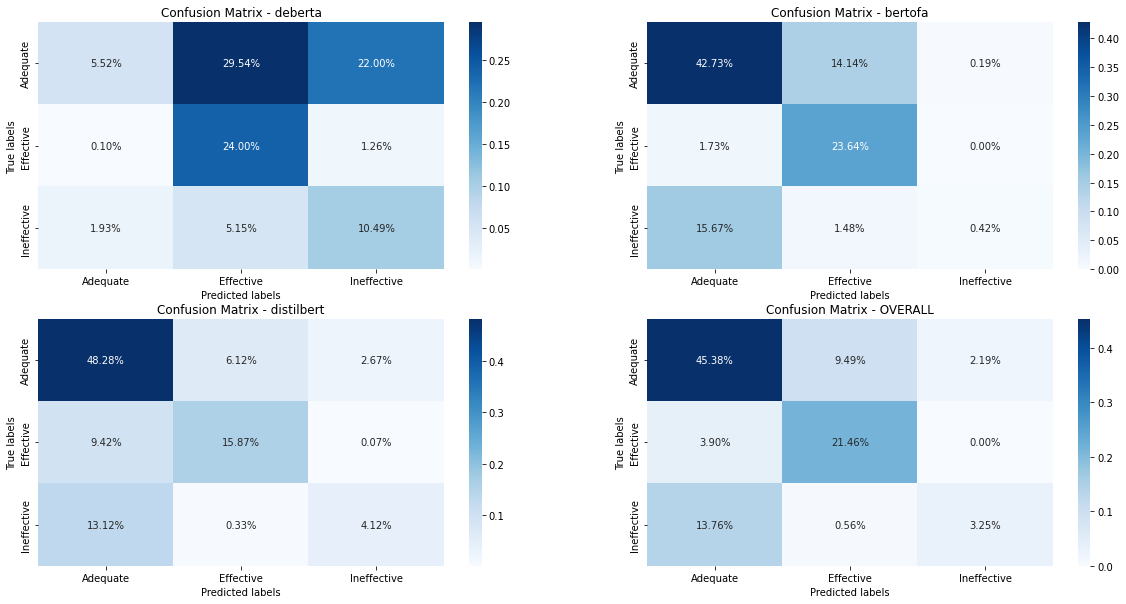

In [60]:

preds = ['deberta','distilbert','bertofa','OVERALL']

output1, output2, output3, output4 = validate_result(ypred_deberta,ypred_distilbert,ypred_bertofa,weight,val_path, preds)



## Read F1 Score for each class

In [61]:

f1_score_df = pd.DataFrame({'deberta':output1[0].tolist(),
                         'distilbert':output2[0].tolist(),
                         'bertofa':output3[0].tolist(),
                         'overall':output4[0].tolist(),
                            })
f1_score_df['label']=attributes
f1_score_df.set_index(['label'])



,deberta,distilbert,bertofa,overall
label,,,,
Adequate,0.170911,0.754998,0.729256,0.755661
Effective,0.571105,0.665716,0.731481,0.754663
Ineffective,0.408585,0.337416,0.046372,0.282506


## Read weighted average f1 score from various models, including ensembled model

In [62]:
f1_weight_score = []
f1_weight_score.append(output1[1].item())
f1_weight_score.append(output2[1].item())
f1_weight_score.append(output3[1].item())
f1_weight_score.append(output4[1].item())
f1_weight_score

logloss_score = []
logloss_score.append(output1[2].item())
logloss_score.append(output2[2].item())
logloss_score.append(output3[2].item())
logloss_score.append(output4[2].item())
logloss_score

score_df = pd.DataFrame({'f1_weighted_score':f1_weight_score})
score_df['log loss'] = logloss_score
score_df['model']=preds
score_df

,f1_weighted_score,log loss,model
0,0.314177,1.583759,deberta
1,0.658979,0.712088,distilbert
2,0.609831,0.728091,bertofa
3,0.672270,0.668112,OVERALL


## Read text with wrong classification

In [63]:
y_pred_overall = (ypred_deberta*weight['deberta'] + ypred_distilbert*weight['distilbert'] + ypred_bertofa*weight['bertofa'])/(weight['deberta']+weight['distilbert']+weight['bertofa'])
argmax_output = y_pred_overall.argmax(dim=1)
argmax_output = argmax_output.numpy()
output_overall_df = pd.concat([val_df.reset_index(drop=True), pd.DataFrame(argmax_output,columns=['pred_discourse_effectiveness'])], axis=1)
output_overall_df['pred_discourse_effectiveness'] = output_overall_df['pred_discourse_effectiveness'].map({0:'Adequate',1:'Effective',2:'Ineffective'})

output_overall_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7353 entries, 0 to 7352
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   discourse_id                  7353 non-null   object
 1   essay_id                      7353 non-null   object
 2   discourse_text                7353 non-null   object
 3   discourse_type                7353 non-null   object
 4   discourse_effectiveness       7353 non-null   object
 5   essay_text                    7353 non-null   object
 6   text                          7353 non-null   object
 7   pred_discourse_effectiveness  7353 non-null   object
dtypes: object(8)
memory usage: 459.7+ KB


In [64]:
bad_pred_df = output_overall_df[output_overall_df['pred_discourse_effectiveness']!=output_overall_df['discourse_effectiveness']]
ineffective_bad_pred_df = bad_pred_df.loc[(bad_pred_df['pred_discourse_effectiveness']!=bad_pred_df['discourse_effectiveness'])& (bad_pred_df['discourse_effectiveness']=='Ineffective')]

In [65]:
def get_text(ids):
    # with open(f'../input/feedback-prize-effectiveness/train/{ids}.txt', 'r') as file: data = file.read()
    with open(f'/content/drive/MyDrive/Colab Notebooks/Data/train/{ids}.txt', 'r') as file: data = file.read()
    return data

def display_sample(essay_id,bad_df,train_df):
    char_pos = 0
    ex = [{"text": '',"ents": [],"title":""}]
    ex2 = [{"text": '',"ents": [],"title":""}]
    text = ''
    for idx in range(train_df.loc[(train_df['essay_id']==essay_id)].shape[0]):
        
        discourse_text = train_df.loc[(df.essay_id == essay_id),'discourse_text'].values[idx]
        discourse_text = resolve_encodings_and_normalize(discourse_text)
        begin = char_pos
        end = begin + len(discourse_text)
        discoursetype = train_df.loc[(train_df.essay_id == essay_id),'discourse_type'].values[idx]
        discourse_id = train_df.loc[(train_df.essay_id == essay_id),'discourse_id'].values[idx]
        
        if bad_df[bad_df.discourse_id == discourse_id].shape[0] != 0:
            label_bad = bad_df.loc[(bad_df.discourse_id == discourse_id),'pred_discourse_effectiveness'].values[0]
            label_good = bad_df.loc[(bad_df.discourse_id == discourse_id),'discourse_effectiveness'].values[0]
            ex[0]['ents'].append({"start":begin,
                  "end":end,
                  "label":label_bad + '/' + label_good+ ' (Predict/True)' + ' - ' + discoursetype
                    })

            ex2[0]['ents'].append({"start":begin,
                  "end":end,
                  "label":label_good + ' - ' + discoursetype + ' (True)'
                    })
        char_pos = end
        text += discourse_text
    ex[0]['text']=text
    ex2[0]['text']=text
    ex[0]['title']=f"Essay ID: {essay_id}"
    displacy.render(ex, style="ent", manual=True,jupyter=True,options={"distance":100})
    print()
#     displacy.render(ex2, style="ent", manual=True,jupyter=True,options={"distance":100})
    return





In [66]:
sample_id = ineffective_bad_pred_df.sample(1)['essay_id'].values[0]
display_sample(sample_id,bad_pred_df,data_path.sort_index())

# PREDICTION AND KAGGLE SUBMISSION
---

https://www.kaggle.com/competitions/feedback-prize-effectiveness


## Main function to execute prediction on test dataset

In [42]:
def predict(_Text_Classifier,config):
    try:
      data_path = pd.read_csv('/kaggle/input/feedback-prize-effectiveness/train.csv')
      test_path = pd.read_csv('/kaggle/input/feedback-prize-effectiveness/test.csv')
    except:
      data_path = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/train.csv')
      test_path = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/test.csv')

    attributes = ["Adequate" ,"Effective","Ineffective"]
    config['model_name'] = config['existing_tuned_model_name']
    tokenizer = AutoTokenizer.from_pretrained(config['model_name'], use_fast=True)
    le = LabelEncoder()
    
    # Initialize data module
    test_data_module = _Data_Module(data_path,
                                    test_path,
                                    attributes,
                                    le,
                                    tokenizer,
                                    config['model_name'],
                                    batch_size=config['batch_size'],
                                    text_method = config['text_method']
                                   )
    test_data_module.setup()

    # Initialize Model
    model = _Text_Classifier(config,test_data_module)
    # model.load_state_dict(torch.load(config['PATH']))

    # Initialize Trainer
    trainer = pl.Trainer(accelerator='auto')

    # Run predictions
    def predict_text_classification(model, dm):
        predictions = trainer.predict(model, datamodule=dm)
        return predictions
    predictions = predict_text_classification(model, test_data_module)

    # Pass logit into a softmax
    pred_list = []
    for logits in predictions:
        pred_list.append(logits)
    y_pred = torch.cat(pred_list)
    y_pred.shape

    softmax_outputs = softmax(y_pred, axis=1)
    test_df = test_path.copy()
    output_df = pd.concat([test_df[['discourse_id']].reset_index(drop=True), pd.DataFrame(softmax_outputs.numpy(), columns=attributes)], axis=1)
#     output_df = pd.concat([test_df[['discourse_id']].reset_index(drop=True), pd.DataFrame(y_pred.numpy(), columns=attributes)], axis=1)
    new_cols = ["discourse_id","Ineffective","Adequate","Effective"]
    output_df = output_df[new_cols]

    return output_df, y_pred

## Predict using multiple models

In [43]:

output_DeBerta, y_pred_deberta = predict(DeBerta_Text_Classifier,deberta_config)
output_DistilBert, y_pred_distilbert = predict(DistilBert_Text_Classifier,distilbert_config)
output_BertOFA, y_pred_bertofa = predict(BertOFA_Text_Classifier,bertofa_config)
# output_distilRoBerta = predict(DistilRoBerta_Text_Classifier,distilroberta_config)



Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loops/utilities.py:95: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  category=PossibleUserWarning,
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


['embeddings.word_embeddings.weight', 'embeddings.LayerNorm.weight', 'embeddings.LayerNorm.bias', 'encoder.layer.0.attention.self.query_proj.weight', 'encoder.layer.0.attention.self.query_proj.bias', 'encoder.layer.0.attention.self.key_proj.weight', 'encoder.layer.0.attention.self.key_proj.bias', 'encoder.layer.0.attention.self.value_proj.weight', 'encoder.layer.0.attention.self.value_proj.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.output.dense.weight', 'encoder.layer.0.output.dense.bias', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.1.attention.self.query_proj.weight', 'encoder.layer.1.attention.self.query_proj.bias', 'encoder.layer.1.attention.self.key_proj.weight', 

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loops/utilities.py:95: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  category=PossibleUserWarning,
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


['embeddings.word_embeddings.weight', 'embeddings.position_embeddings.weight', 'embeddings.LayerNorm.weight', 'embeddings.LayerNorm.bias', 'transformer.layer.0.attention.q_lin.weight', 'transformer.layer.0.attention.q_lin.bias', 'transformer.layer.0.attention.k_lin.weight', 'transformer.layer.0.attention.k_lin.bias', 'transformer.layer.0.attention.v_lin.weight', 'transformer.layer.0.attention.v_lin.bias', 'transformer.layer.0.attention.out_lin.weight', 'transformer.layer.0.attention.out_lin.bias', 'transformer.layer.0.sa_layer_norm.weight', 'transformer.layer.0.sa_layer_norm.bias', 'transformer.layer.0.ffn.lin1.weight', 'transformer.layer.0.ffn.lin1.bias', 'transformer.layer.0.ffn.lin2.weight', 'transformer.layer.0.ffn.lin2.bias', 'transformer.layer.0.output_layer_norm.weight', 'transformer.layer.0.output_layer_norm.bias', 'transformer.layer.1.attention.q_lin.weight', 'transformer.layer.1.attention.q_lin.bias', 'transformer.layer.1.attention.k_lin.weight', 'transformer.layer.1.attentio

Predicting: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loops/utilities.py:95: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  category=PossibleUserWarning,
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


['embeddings.word_embeddings.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.LayerNorm.weight', 'embeddings.LayerNorm.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.value.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.output.dense.weight', 'encoder.layer.0.output.dense.bias', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.1.attention.self.query.weight', 'encoder.layer.1.attention.self.query.bias', 'encod

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [44]:

# output_df = output_DeBerta.copy()

# for attribute in attributes:
#     output_df[attribute] =  (output_DeBerta[attribute]*weight['deberta'] + 
#                             output_DistilBert[attribute]*weight['distilbert'] + 
#                             output_BertOFA[attribute]*weight['bertofa'])/(weight['deberta']+weight['distilbert']+weight['bertofa'])
# for atttribute in attributes:
#     output_df[attribute] =  (output_DeBerta[attribute]*weight['deberta'] + 
#                             output_DistilBert[attribute]*weight['distilbert'] + 
#                             output_BertOFA[attribute]*weight['bertofa'] +
#                             output_distilRoBerta[attribute]*weight['distilroberta'])/4

# output_df

## Ensemble predicted values by various model and pass it to softmax to normalize data to be between 0 to 1

In [45]:
weight_deberta = torch.tensor([weight['deberta']])
weight_distilbert = torch.tensor([weight['distilbert']])
weight_bertofa = torch.tensor([weight['bertofa']])

weight_deberta=weight_deberta.repeat(y_pred_deberta.shape[0],1)
weight_distilbert=weight_distilbert.repeat(y_pred_distilbert.shape[0],1)
weight_bertofa=weight_bertofa.repeat(y_pred_bertofa.shape[0],1)
        
for idx,ypred in enumerate(y_pred_deberta):
    if (ypred[2]>ypred[0]) &(ypred[2]>ypred[1]):
        ratio_bertofa = weight_bertofa[idx]/(weight_distilbert[idx]+weight_deberta[idx])
        ratio_distilbert = weight_distilbert[idx]/(weight_bertofa[idx]+weight_deberta[idx])
        weight_deberta[idx]=0.6
        weight_bertofa[idx]=0.02
        weight_distilbert[idx]=0.38 
        
numerator = torch.mul(y_pred_deberta,weight_deberta) + torch.mul(y_pred_distilbert,weight_bertofa) + torch.mul(y_pred_bertofa,weight_distilbert)
denominator = torch.add(torch.add(weight_deberta,weight_bertofa),weight_distilbert)
y_pred_overall = torch.div(numerator,denominator)

softmax_outputs = softmax(y_pred_overall, axis=1)

In [46]:
# Create dataframe for submission
output_df = pd.concat([test_path[['discourse_id']].reset_index(drop=True), pd.DataFrame(softmax_outputs.numpy(), columns=attributes)], axis=1)
#     output_df = pd.concat([test_df[['discourse_id']].reset_index(drop=True), pd.DataFrame(y_pred.numpy(), columns=attributes)], axis=1)

# Re-arrange columns
new_cols = ["discourse_id","Ineffective","Adequate","Effective"]
output_df = output_df[new_cols]




In [47]:
output_df.to_csv('/content/drive/MyDrive/Colab Notebooks/FineTuneModel/ValidationResult/submission.csv', index=False)
pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FineTuneModel/ValidationResult/submission.csv')

,discourse_id,Ineffective,Adequate,Effective
0,a261b6e14276,0.425131,0.198899,0.375970
1,5a88900e7dc1,0.425028,0.215980,0.358992
2,9790d835736b,0.422121,0.220301,0.357578
3,75ce6d68b67b,0.421955,0.218040,0.360006
4,93578d946723,0.422687,0.219680,0.357633
5,2e214524dbe3,0.423836,0.191135,0.385029
6,84812fc2ab9f,0.408738,0.204556,0.386706
7,c668ff840720,0.423422,0.216921,0.359657
8,739a6d00f44a,0.419416,0.196767,0.383817
9,bcfae2c9a244,0.434176,0.196534,0.369289
